In [ ]:
#Install the nessesery pakadges and restart the runtime if needed 
!pip install pennylane-qchem
!pip install 
!pip install pennylane-qiskit

##May have to restart the runtime after the pip instalations above


In [ ]:
#have to restart the runtime after pip instalations above

In [15]:
#https://pennylaneqiskit.readthedocs.io/en/latest/index.html
from qiskit import IBMQ

#MY_API_TOKEN=""
IBMQ.save_account(MY_API_TOKEN)

In [2]:
#may have to restart the runtime after pip instalations
import pennylane as qml #https://pennylane.ai/qml/demonstrations.html
from pennylane import numpy as np

In [3]:
name = 'h2'
charge = 0
multiplicity = 1
basis_set = 'sto-3g'
geometry = 'h2.xyz' #may have to upload the file by hand into the cwd

In [4]:
h, nr_qubits = qml.qchem.generate_hamiltonian(
    name,
    geometry,
    charge,
    multiplicity,
    basis_set,
    n_active_electrons=2,
    n_active_orbitals=2,
    mapping='jordan_wigner'
)

print('Number of qubits = ', nr_qubits)
print('Hamiltonian is ', h)

Number of qubits =  4
Hamiltonian is  (-0.04207897647782276) [I0]
+ (0.17771287465139946) [Z0]
+ (0.1777128746513994) [Z1]
+ (-0.24274280513140462) [Z2]
+ (-0.24274280513140462) [Z3]
+ (0.17059738328801052) [Z0 Z1]
+ (0.04475014401535161) [Y0 X1 X2 Y3]
+ (-0.04475014401535161) [Y0 Y1 X2 X3]
+ (-0.04475014401535161) [X0 X1 Y2 Y3]
+ (0.04475014401535161) [X0 Y1 Y2 X3]
+ (0.12293305056183798) [Z0 Z2]
+ (0.1676831945771896) [Z0 Z3]
+ (0.1676831945771896) [Z1 Z2]
+ (0.12293305056183798) [Z1 Z3]
+ (0.17627640804319591) [Z2 Z3]


That's it! From here on, we can use PennyLane as usual, employing its entire stack of
algorithms and optimizers.

Implementing the VQE algorithm
------------------------------

PennyLane contains the `VQECost` class, specifically
built to implement the VQE algorithm. We begin by defining the device, in this case a simple
qubit simulator:



In [5]:
#check the avilable backends
#https://pennylane.readthedocs.io/en/stable/introduction/configuration.html
#print(qml.default_config.path)

import pkg_resources
{entry.name: entry for entry in pkg_resources.iter_entry_points("pennylane.plugins")}

{'default.gaussian': EntryPoint.parse('default.gaussian = pennylane.plugins:DefaultGaussian'),
 'default.qubit': EntryPoint.parse('default.qubit = pennylane.plugins:DefaultQubit'),
 'default.qubit.tf': EntryPoint.parse('default.qubit.tf = pennylane.plugins.default_qubit_tf:DefaultQubitTF'),
 'default.tensor': EntryPoint.parse('default.tensor = pennylane.beta.plugins.default_tensor:DefaultTensor'),
 'default.tensor.tf': EntryPoint.parse('default.tensor.tf = pennylane.beta.plugins.default_tensor_tf:DefaultTensorTF'),
 'qiskit.aer': EntryPoint.parse('qiskit.aer = pennylane_qiskit:AerDevice'),
 'qiskit.basicaer': EntryPoint.parse('qiskit.basicaer = pennylane_qiskit:BasicAerDevice'),
 'qiskit.ibmq': EntryPoint.parse('qiskit.ibmq = pennylane_qiskit:IBMQDevice')}

Simple variatinal circuit for $H_2$ VQE

In [7]:
def circuit(params, wires):
    qml.BasisState(np.array([1, 1, 0, 0]), wires=wires)
    for i in wires:
        qml.Rot(*params[i], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

In [8]:
dev = qml.device('default.qubit', wires=nr_qubits)

In [9]:
cost_fn = qml.VQECost(circuit, h, dev)

In [10]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)
np.random.seed(0)
params = np.random.normal(0, np.pi, (nr_qubits, 3))

print(params)

[[ 5.54193389  1.25713095  3.07479606]
 [ 7.03997361  5.86710646 -3.07020901]
 [ 2.98479079 -0.47550269 -0.32427159]
 [ 1.28993324  0.45252622  4.56873497]]


In [11]:
max_iterations = 200
conv_tol = 1e-06

prev_energy = cost_fn(params)
for n in range(max_iterations):
    params = opt.step(cost_fn, params)
    energy = cost_fn(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print('Iteration: {:},\tGround-state energy = {:.8f} Ha.\t(conv/tol: {:.0f})'.format(n, energy, conv/(conv_tol)))

    if conv <= conv_tol:
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final ground-state energy = {:.8f} Ha'.format(energy))
print('Accuracy with respect to FCI: {:.8f} Ha ({:.8f} kcal/mol)'.
        format(np.abs(energy - (-1.136189454088)), np.abs(energy - (-1.136189454088))*627.503))


Iteration: 0,	Ground-state energy = -0.88179557 Ha.	(conv/tol: 74326)
Iteration: 20,	Ground-state energy = -1.13380513 Ha.	(conv/tol: 437)
Iteration: 40,	Ground-state energy = -1.13558756 Ha.	(conv/tol: 19)
Iteration: 60,	Ground-state energy = -1.13585794 Ha.	(conv/tol: 10)
Iteration: 80,	Ground-state energy = -1.13600617 Ha.	(conv/tol: 6)
Iteration: 100,	Ground-state energy = -1.13608848 Ha.	(conv/tol: 3)
Iteration: 120,	Ground-state energy = -1.13613394 Ha.	(conv/tol: 2)

Final convergence parameter = 0.00000099 Ha
Final ground-state energy = -1.13615709 Ha
Accuracy with respect to FCI: 0.00003237 Ha (0.02031093 kcal/mol)


Success! 🎉🎉🎉 The ground-state energy of the hydrogen molecule has been estimated with chemical
accuracy (< 1 kcal/mol) with respect to the exact value of -1.136189454088 Hartree (Ha) obtained
from a full configuration-interaction (FCI) calculation. This is because, for the optimized
values of the single-qubit rotation angles, the state prepared by the VQE ansatz is precisely
the FCI ground-state of the $H_2$ molecule $|H_2\rangle_{gs} = 0.99 |1100\rangle - 0.10
|0011\rangle$.

What other molecules would you like to study using PennyLane?

#Run on an actual quantum device!

In [20]:
#just make sure that this simple circuit is going to be excesuted on ibmq deice

dev = qml.device('qiskit.ibmq', wires=2, backend='ibmq_essex',shots=100)

# Create a PennyLane quantum node run on the device
@qml.qnode(dev)
def test_circuit(x, y, z):
    qml.RZ(z, wires=[0])
    qml.RY(y, wires=[0])
    qml.RX(x, wires=[0])
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliZ(wires=1))

# Result of noisy simulator
%time print(test_circuit(0.2, 0.1, 0.3),dev)


0.8 Qiskit PennyLane plugin
Short name: qiskit.ibmq
Package: pennylane_qiskit
Plugin version: 0.9.0
Author: Xanadu
Wires: 2
Shots: 100
CPU times: user 68.6 ms, sys: 2.09 ms, total: 70.7 ms
Wall time: 1min 3s


In [21]:
#get the energy using ibmq devise if avilable

PennyLane=[]
IBM=[]
PnyLn_or_IBM=[]

for i in range(10):
  params = np.random.normal(0, np.pi, (nr_qubits, 3))

  dev = qml.device('default.qubit', wires=nr_qubits)
  cost_fn = qml.VQECost(circuit, h, dev)
  energy = cost_fn(params)

  if energy < 0:

    PennyLane.append(energy)
    print("E=",energy," computed with ",dev)
    print()

    #try:
    dev = qml.device('qiskit.ibmq', wires=nr_qubits, backend='ibmq_essex',shots=100)
    print(dev.capabilities()['backend'])

    cost_fn = qml.VQECost(circuit, h, dev)
    %time energy = cost_fn(params)
    IBM.append(energy)

    print("E=",energy," computed with ",dev)
    print()

    #except:
    dev = qml.device('default.qubit', wires=nr_qubits)
    #cost_fn = qml.VQECost(circuit, h, dev)
    energy = cost_fn(params)
    PnyLn_or_IBM.append(energy)

    print("E=",energy," computed with ",dev)


E= -0.18132612815869054  computed with  Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.10.0
Author: Xanadu Inc.
Wires: 4
Shots: 1000

['ibmq_qasm_simulator', 'ibmqx2', 'ibmq_16_melbourne', 'ibmq_vigo', 'ibmq_ourense', 'ibmq_london', 'ibmq_burlington', 'ibmq_essex', 'ibmq_armonk']
CPU times: user 950 ms, sys: 52.4 ms, total: 1 s
Wall time: 7min 16s
E= -0.3148574027460309  computed with  Qiskit PennyLane plugin
Short name: qiskit.ibmq
Package: pennylane_qiskit
Plugin version: 0.9.0
Author: Xanadu
Wires: 4
Shots: 100

E= -0.12324859734621739  computed with  Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.10.0
Author: Xanadu Inc.
Wires: 4
Shots: 1000
E= -0.13505008078531075  computed with  Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.10.0
Author: Xanadu Inc.
Wires: 4
Shots: 1000

['ibmq_qasm_simulator', 'ibmqx2', 'ibmq_16_melbourne', 'ibmq_vigo', 'ib

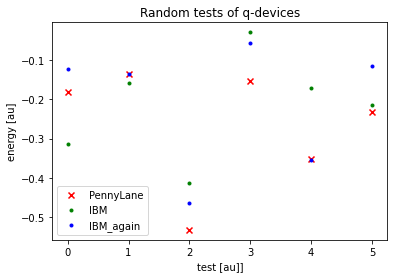

In [22]:
#In case one have to restart and remove some values
#PennyLane=PennyLane[0:6,7:]

#Plot the PESs
import matplotlib.pyplot as plt

title_text="Random tests of q-devices"
plt.title(title_text)
plt.xlabel('test [au]]')
plt.ylabel('energy [au]')

plt.scatter(range(len(PennyLane)), PennyLane, label='PennyLane',marker='x', color='r')
plt.scatter(range(len(IBM)), IBM, label='IBM', marker='.',color='g')
plt.scatter(range(len(PnyLn_or_IBM)), PnyLn_or_IBM, label='IBM_again', marker='.',color='b')
plt.legend()


Notice that tehre is about $\pm0.2$ error !